Part 3 contains:
1. Imbalanced learning handling
2. Feature processing
3. Modeling

In [30]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, precision_score, accuracy_score

from xgboost import XGBClassifier

from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE

from imblearn.under_sampling import TomekLinks
from collections import Counter

from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC

In [3]:
# load the dataset
full_df = pd.read_csv("../Datasets/ready_to_model_data.csv", sep=",")

In [4]:
# the majority of the values in created acount are missing
# target for the model, is the output variable which is "created_account"
n_missing_account = full_df[full_df["created_account"].isnull()].shape[0]
print(f"The created account column has many missing values. {round(n_missing_account/full_df.shape[0]*100,2)}% of them are set to NaN.")

# Assumption 1: No assumption, do not use the data for the modeling part
full_df_small = full_df[~full_df["created_account"].isnull()]

# Assumption 2: The campaign participant did not respond back and we are missing this information
# We can assume that the participant did not respond, as he is not interested ino creating the account -- replace the value with 0
full_df_assump = full_df.copy()
full_df_assump.loc[full_df_assump["created_account"].isnull(), "created_account"] = "No"

The created account column has many missing values. 90.63% of them are set to NaN.


[Text(0.5, 1.0, 'Imbalanced nature of output variable'),
 Text(0.5, 0, 'Participant created account')]

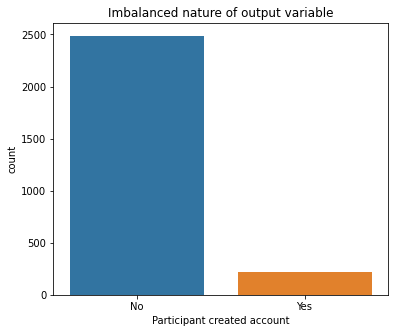

In [5]:
# regardless of the dataset that we decide to use, the output is severelly unbalanced
# such targers require special handling, both in terms of handling the output but also in the metrics

plt.figure(figsize=(6, 5))

splot= sns.countplot(data=full_df_small, x="created_account")
splot.set(title="Imbalanced nature of output variable",
          xlabel="Participant created account")

In [7]:
# split the data into train and test set before any dataset processing
X, y = full_df_small.drop(columns=["created_account"]), full_df_small["created_account"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, stratify=y)

<ins>Feature handling</ins>  

Most machine learning algorithms cannot handle categorical variables; therefore they need to be encoded before they can be used by a model.  
Here, I will use one-hot encoding (replace each distinct value of the variable with a vectors of 0s and 1s) on the categorical variables, as it is:
* fast
* easy to implement
* does not assume a natural ranking of the values of the categorical variable  

Last, the known issue with one-hot encoding is that there can be a large increase in the number of features (curse of Dimentionality).  
However, this is not the case with the variables that I decided to retain do not have high dimentions

In [9]:
categorical_variables = [
    "marital_status",
    "workclass"
]

# --- --- --- helper --- --- ---
def add_oh_encoded_cols(dataframe, variable_name, oh_encoder, remove_original=True):
    """Given the dataframe and an one hot encoder, encode the values of the variable and replace them on the dataframe
    """
    encoded = oh_encoder.transform(dataframe[[variable_name]])

    # create a new dataframe with the encoded values
    encoded_names = oh_encoder.get_feature_names_out()
    encoded_df = pd.DataFrame(data=encoded, columns=encoded_names, index=dataframe.index)
    encoded_df = encoded_df.astype({col_name: int for col_name in encoded_names})
    dataframe = pd.concat([dataframe, encoded_df], axis=1)

    if remove_original:
        # remove the previous feature column
        dataframe = dataframe.drop(columns=[variable_name])

    return dataframe


for c in categorical_variables:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False, drop=None)
    encoded = encoder.fit(X_train[[c]])

    X_train = add_oh_encoded_cols(X_train, c, encoder)
    X_test = add_oh_encoded_cols(X_test, c, encoder)



In [10]:
# encode binary variables
# created account --> No: 0, Yes: 1
# sex --> Male: 0, Female: 1

replacement_dict = {"No": 0, "Yes": 1}
y_train = y_train.replace(replacement_dict)
y_test = y_test.replace(replacement_dict)

replacement_dict = {"Male": 0, "Female": 1}
X_train["sex"] = X_train["sex"].replace(replacement_dict)
X_test["sex"] = X_test["sex"].replace(replacement_dict)

In [13]:
# min max scaler used on numeric variables
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Approach 1
# Work in the smaller dataset, it can be thought as a dataset that has the "Noes" sampled from the original data while retaining all the "Yeses"
# No other special handling for the target variable


# --- --- --- helper --- --- ---
def visualize_prediction_results(classification_model, X_train, y_train, X_test, y_test):
    classification_model.fit(X_train, y_train)
    pred = classification_model.predict(X_test)
    pred_proba = classification_model.predict_proba(X_test)

    print("Classification report")
    print(classification_report_imbalanced(y_test, pred))

    print("Confusion matrix")
    print(confusion_matrix(y_test, pred))
        
    viz = PrecisionRecallCurve(classification_model, classes=["no account", "new account"], macro=True, binary=True)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()


    viz = ROCAUC(classification_model, classes=["no account", "new account"], macro=True, binary=True)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()

    return pred, pred_proba

Random Forest results
Classification report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.89      0.99      0.94      0.90       622
          1       0.94      0.89      1.00      0.92      0.94      0.88        55

avg / total       0.99      0.99      0.90      0.99      0.94      0.89       677

Confusion matrix
[[619   3]
 [  6  49]]


c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


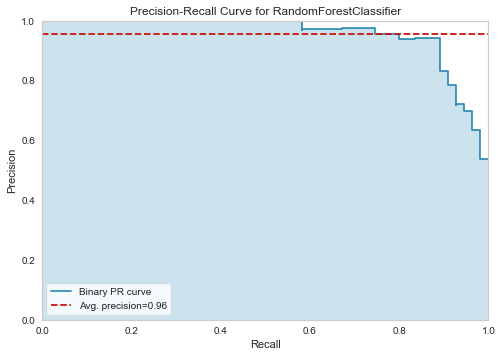

c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


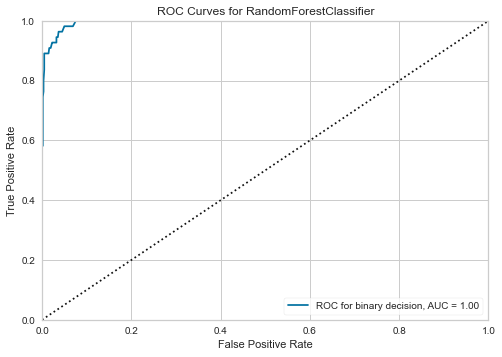

XGBoost results
[22:41:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.87      0.99      0.93      0.88       622
          1       0.92      0.87      0.99      0.90      0.93      0.86        55

avg / total       0.98      0.98      0.88      0.98      0.93      0.88       677

Confusion matrix
[[618   4]
 [  7  48]]


c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  eli

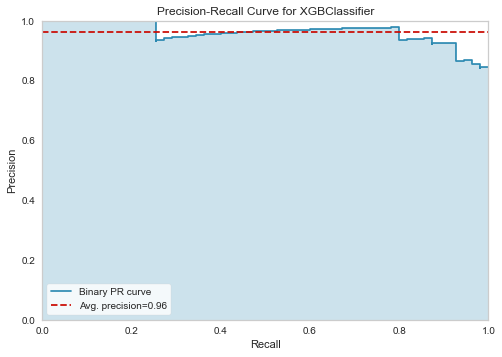

c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


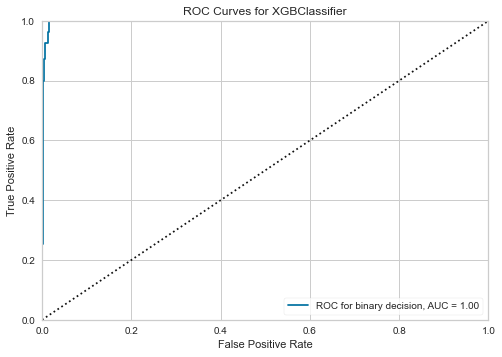

SVM results
Classification report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.85      0.99      0.92      0.85       622
          1       0.84      0.85      0.99      0.85      0.92      0.83        55

avg / total       0.98      0.97      0.87      0.97      0.92      0.85       677

Confusion matrix
[[613   9]
 [  8  47]]


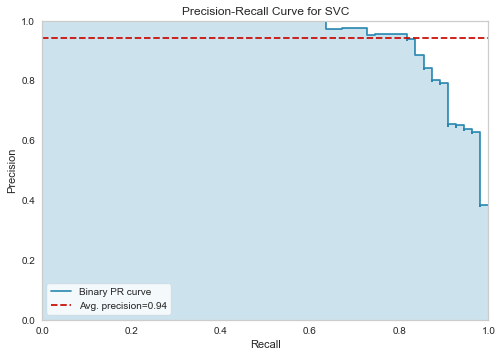

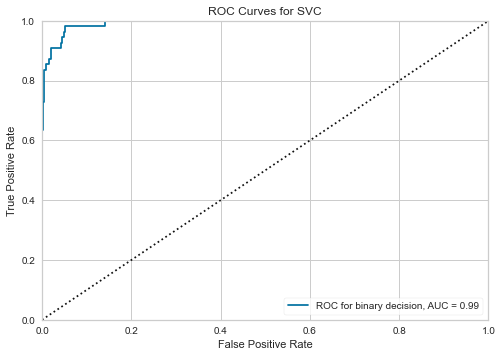

Naive Bayes results
Classification report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.53      0.96      0.69      0.72      0.49       622
          1       0.15      0.96      0.53      0.27      0.72      0.53        55

avg / total       0.93      0.57      0.93      0.66      0.72      0.49       677

Confusion matrix
[[331 291]
 [  2  53]]


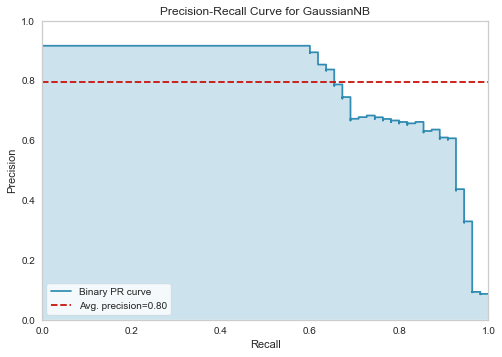

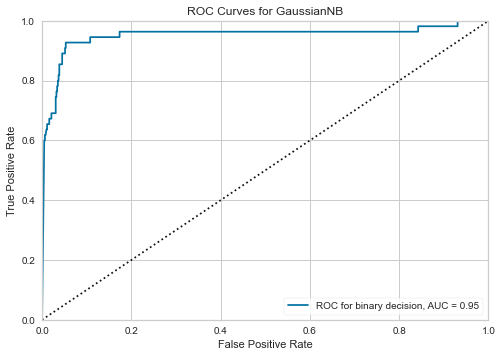

Logistic regression results
Classification report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.85      0.99      0.92      0.86       622
          1       0.94      0.85      1.00      0.90      0.92      0.84        55

avg / total       0.98      0.98      0.87      0.98      0.92      0.86       677

Confusion matrix
[[619   3]
 [  8  47]]


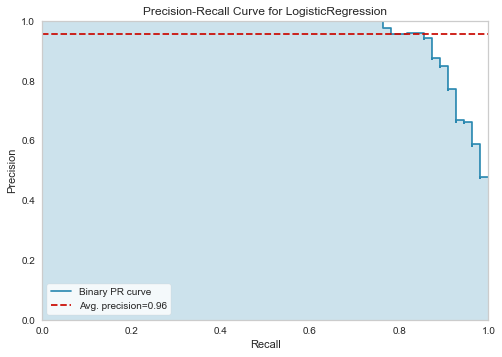

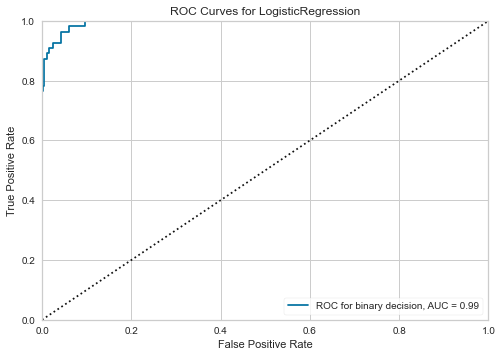

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [20]:
clf_rf = RandomForestClassifier()
clf_xgb = XGBClassifier()
clf_svm = SVC(probability=True)
clf_nb = GaussianNB()
clf_lr = LogisticRegression()

print("Random Forest results")
visualize_prediction_results(clf_rf, X_train, y_train, X_test, y_test)
print("XGBoost results")
visualize_prediction_results(clf_xgb, X_train, y_train, X_test, y_test)
print("SVM results")
visualize_prediction_results(clf_svm, X_train_scaled, y_train, X_test_scaled, y_test)
print("Naive Bayes results")
visualize_prediction_results(clf_nb, X_train_scaled, y_train, X_test_scaled, y_test)
print("Logistic regression results")
visualize_prediction_results(clf_lr, X_train_scaled, y_train, X_test_scaled, y_test)

In [22]:
# Since the data of full_df_small are already downsampled on the negative class
# I will use only oversampling techniques
# 1. Random over sampling

# 0.08 of the test set data --> 0.2 of the test set cases
ros = RandomOverSampler(random_state=256, sampling_strategy=0.2)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print(f"Previous number of observation per output category {Counter(y_train)}")
print(f"Number of examples per category after random oversampling {Counter(y_resampled)}")

Previous number of observation per output category Counter({0: 1864, 1: 165})
Number of examples per category after random oversampling Counter({0: 1864, 1: 372})


Results of XGBoost trained on Random Resamping on the minority class
[23:11:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.93      0.99      0.96      0.93       622
          1       0.94      0.93      1.00      0.94      0.96      0.92        55

avg / total       0.99      0.99      0.93      0.99      0.96      0.93       677

Confusion matrix
[[619   3]
 [  4  51]]


c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


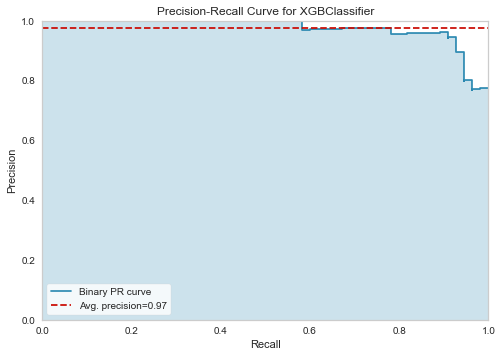

c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


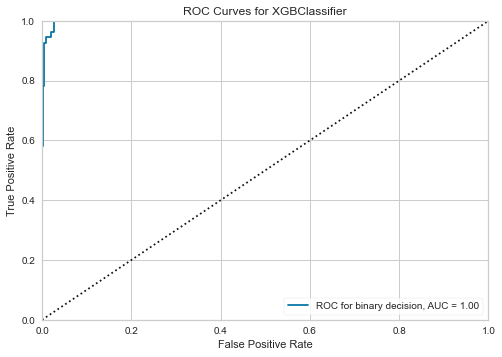

Results of Random Forest trained on Random Resamping on the minority class
Classification report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.91      0.99      0.95      0.91       622
          1       0.93      0.91      0.99      0.92      0.95      0.90        55

avg / total       0.99      0.99      0.92      0.99      0.95      0.91       677

Confusion matrix
[[618   4]
 [  5  50]]


c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


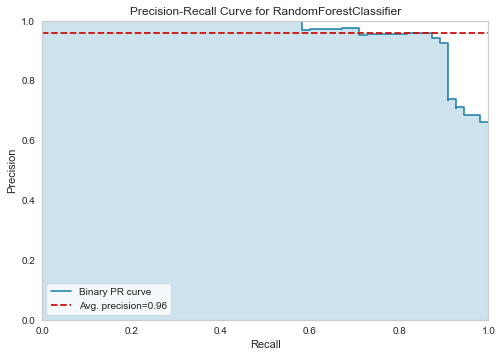

c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


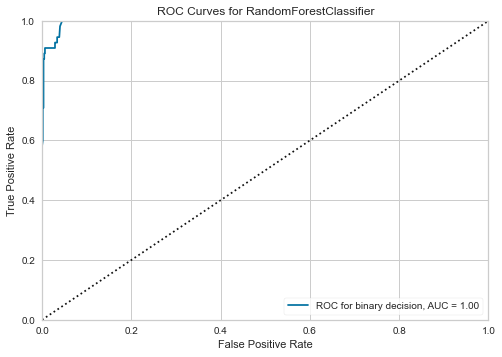

In [23]:
clf1 = XGBClassifier(use_label_encoder=False)
clf2 = RandomForestClassifier()

print("Results of XGBoost trained on Random Resamping on the minority class")
y_pred_xgb, _ = visualize_prediction_results(clf1, X_resampled, y_resampled, X_test, y_test)

print("Results of Random Forest trained on Random Resamping on the minority class")
y_pred_rf, _ = visualize_prediction_results(clf2, X_resampled, y_resampled, X_test, y_test)

In [24]:
# SMOTE oversampling
smote = SMOTE(random_state=256, sampling_strategy=0.16)
# smote = BorderlineSMOTE(random_state=256, sampling_strategy=0.16)

X_smote, y_smote = smote.fit_resample(X_train, y_train)

print(f"Previous number of observation per output category {Counter(y_train)}")
print(f"Number of examples per category after random oversampling {Counter(y_smote)}")

Previous number of observation per output category Counter({0: 1864, 1: 165})
Number of examples per category after random oversampling Counter({0: 1864, 1: 298})


Results of XGBoost trained on SMOTE synthetics data on the minority class
[23:11:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Classification report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.85      0.99      0.92      0.85       622
          1       0.84      0.85      0.99      0.85      0.92      0.83        55

avg / total       0.98      0.97      0.87      0.97      0.92      0.85       677

Confusion matrix
[[613   9]
 [  8  47]]


c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


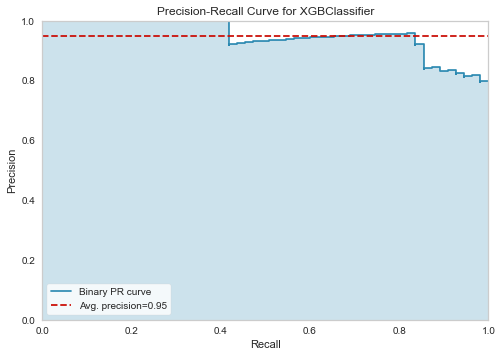

c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


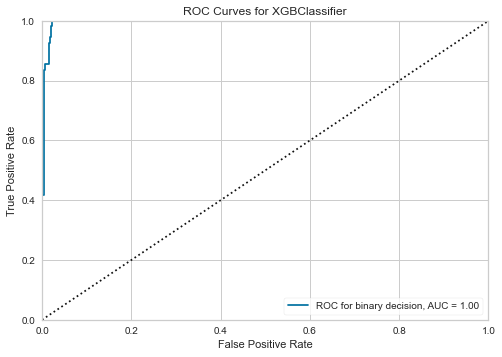

Results of Random Forest trained on SMOTE synthetics data on the minority class
Classification report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.85      0.99      0.92      0.86       622
          1       0.87      0.85      0.99      0.86      0.92      0.83        55

avg / total       0.98      0.98      0.87      0.98      0.92      0.85       677

Confusion matrix
[[615   7]
 [  8  47]]


c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


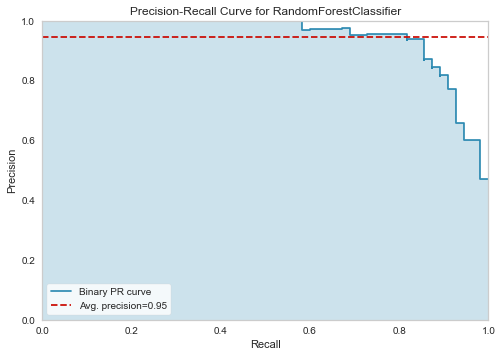

c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


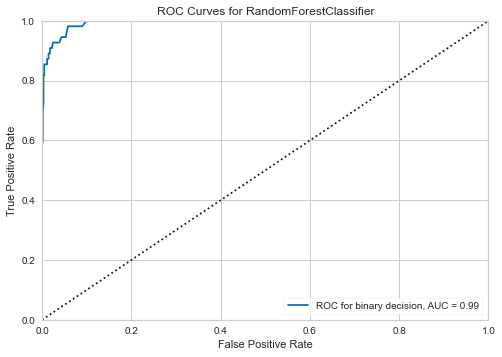

In [25]:
clf1 = XGBClassifier(use_label_encoder=False)
clf2 = RandomForestClassifier()

print("Results of XGBoost trained on SMOTE synthetics data on the minority class")
y_pred_xgb, _ = visualize_prediction_results(clf1, X_smote, y_smote, X_test, y_test)

print("Results of Random Forest trained on SMOTE synthetics data on the minority class")
y_pred_rf, _ = visualize_prediction_results(clf2, X_smote, y_smote, X_test, y_test)

In [26]:
tl = TomekLinks()
X_resampled, y_resampled = tl.fit_resample(X_train, y_train)

print(f"Previous number of observation per output category {Counter(y_train)}")
print(f"Number of examples per category after random oversampling {Counter(y_resampled)}")

Previous number of observation per output category Counter({0: 1864, 1: 165})
Number of examples per category after random oversampling Counter({0: 1842, 1: 165})


Results of XGBoost trained on SMOTE synthetics data on the minority class
[23:11:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.91      0.99      0.95      0.91       622
          1       0.94      0.91      1.00      0.93      0.95      0.90        55

avg / total       0.99      0.99      0.92      0.99      0.95      0.91       677

Confusion matrix
[[619   3]
 [  5  50]]


c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


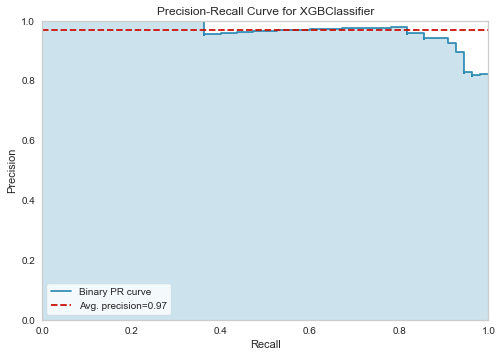

c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


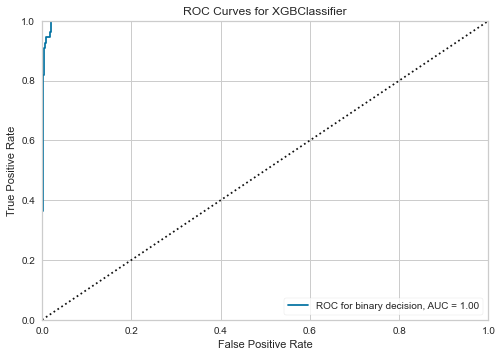

Results of Random Forest trained on SMOTE synthetics data on the minority class
Classification report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.87      0.99      0.93      0.88       622
          1       0.91      0.87      0.99      0.89      0.93      0.86        55

avg / total       0.98      0.98      0.88      0.98      0.93      0.87       677

Confusion matrix
[[617   5]
 [  7  48]]


c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


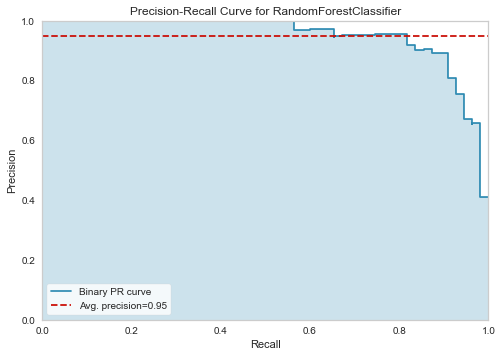

c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


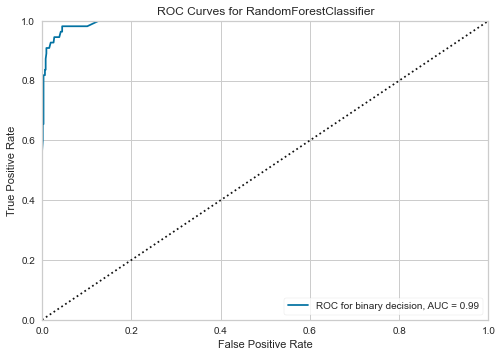

In [27]:
clf1 = XGBClassifier(use_label_encoder=False)
clf2 = RandomForestClassifier()

print("Results of XGBoost trained on SMOTE synthetics data on the minority class")
y_pred_xgb, _ = visualize_prediction_results(clf1, X_resampled, y_resampled, X_test, y_test)

print("Results of Random Forest trained on SMOTE synthetics data on the minority class")
y_pred_rf, _ = visualize_prediction_results(clf2, X_resampled, y_resampled, X_test, y_test)

Hyperparameter tuning for best performant model

In [31]:
clf = XGBClassifier(njobs=-1)

params_grid = {
    "eta": [0.05, 0.15, 0.25, 0.3, 0.35],
    "max_depth": [3, 4, 5, 6, 8],
    "eval_metric": ["error", "auc"],
}

scorers = {
    "precision_score": make_scorer(precision_score),
    "recall_score": make_scorer(recall_score),
    "accuracy_score": make_scorer(accuracy_score),
}


skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(clf, params_grid, scoring=scorers, refit="recall_score",
                            cv=skf, return_train_score=True, n_jobs=-1)
grid_search.fit(X_train.values, y_train.values)

# make the predictions
y_pred = grid_search.predict(X_test.values)

[23:15:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "njobs" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Results of XGBoost trained on original dataset with hyper parameter tunning for recall optimization
[23:15:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "njobs" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Classification report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.91      0.99      0.95      0.91       622
          1       0.94      0.91      1.00      0.93      0.95      0.90        55

avg / total       0.99      0.99      0.92      0.99      0.95      0.91       677

Confusion matrix
[[619   3]
 [  5  50]]


c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


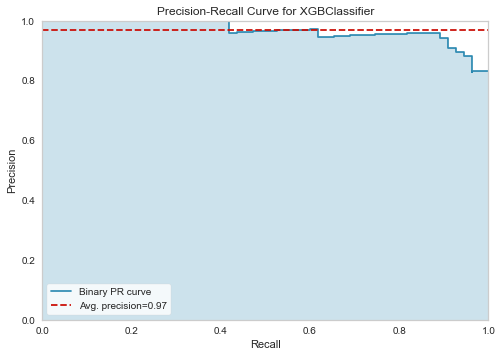

c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Anastasia\Desktop\campainsenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


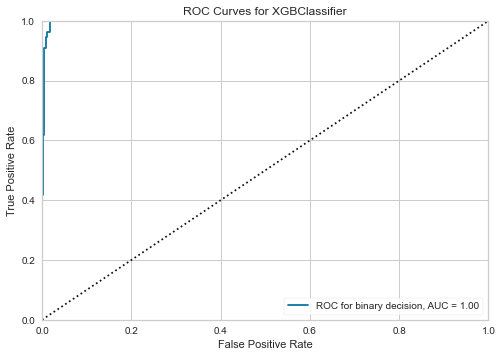

In [32]:
tuned_model = grid_search.best_estimator_
print("Results of XGBoost trained on original dataset with hyper parameter tunning for recall optimization")
y_pred_xgb, _ = visualize_prediction_results(tuned_model, X_train, y_train, X_test, y_test)